# Dependencias y funciones

In [1]:
import requests
import base64
import io
from PIL import Image
import IPython.display

In [2]:
def call(path_to_file='/home/francisco/Documentos/tfm/utils/sample.jpg', url="http://ec2-15-188-9-114.eu-west-3.compute.amazonaws.com:60212/rpc/Hands"):

    payload = {}
    files = [
        ('file', open(path_to_file,'rb'))
    ]
    headers= {}

    response = requests.request("POST", url, headers=headers, data = payload, files = files)

    return response

# Llamada a la API

He sustituido el clúster de OKD por AWS Fargate; cómputo sin servidor para contenedores.

Tan sólo ha sido necesario subir un contenedor docker con mi aplicación a AWS Elastic Container Registry y con AWS Fargate provisionarlos a través de AWS Load Balancer.

Contaré en la memoria que esto proporciona alta disponibilidad, capacidad de escalado en función de la demanda de peticiones, etc.

Lo mejor de todo es que no pagas por máquinas virtuales completas si no por cpu y memoria que usan tus procesos; hay un modo 'spot' que no te asegura que tus aplicaciones se interrumpan pero te hacen un 90% de descuento sobre el precio de uso bajo demanda. El balanceador de carga se ocupa de revisar el estado de los procesos en ejercución para lanzar nuevas instancias de los misos de manera indefinida.

¡¡¡Las peticiones suelen atenderse en 4-5 segundos sin usar GPU!!!

https://aws.amazon.com/es/fargate/?whats-new-cards.sort-by=item.additionalFields.postDateTime&whats-new-cards.sort-order=desc&fargate-blogs.sort-by=item.additionalFields.createdDate&fargate-blogs.sort-order=desc

https://aws.amazon.com/es/ecr/

https://aws.amazon.com/es/elasticloadbalancing/

In [3]:
response = call(path_to_file='/home/ubuntu/tfm/utils/sample.jpg', url="http://tfm-lb-1733482400.eu-west-3.elb.amazonaws.com/rpc/Hands")

In [4]:
data = response.json()
print(f"Request time: {data['elapsed']}s")

Request time: 4.648s


# Tratamiendo de la respuesta

El proceso tiene 3 partes:

    1. Detección de dedos índices + carteles con YOLOv3
    2. Cálculo de area de solapamiento entre caja de dedo + caja de panel, corte de la imagen y proceso de OCR.
    3. Cálculo de la distancia de Levenshtein entre la detección del OCR y los comercios dados de Alta en BBDD. Búsqueda en BBDD y recuperación de mensajes de comercio.

## Paso 1

En la imagen puede verse la detección de los carteles y los dedos índices presentes en la imagen. 

Me estoy quedando con las que tienen confidence >= 75.

Elapsed time: 1.999s
Confidence: 83 Class: 1
Confidence: 90 Class: 1
Confidence: 77 Class: 0


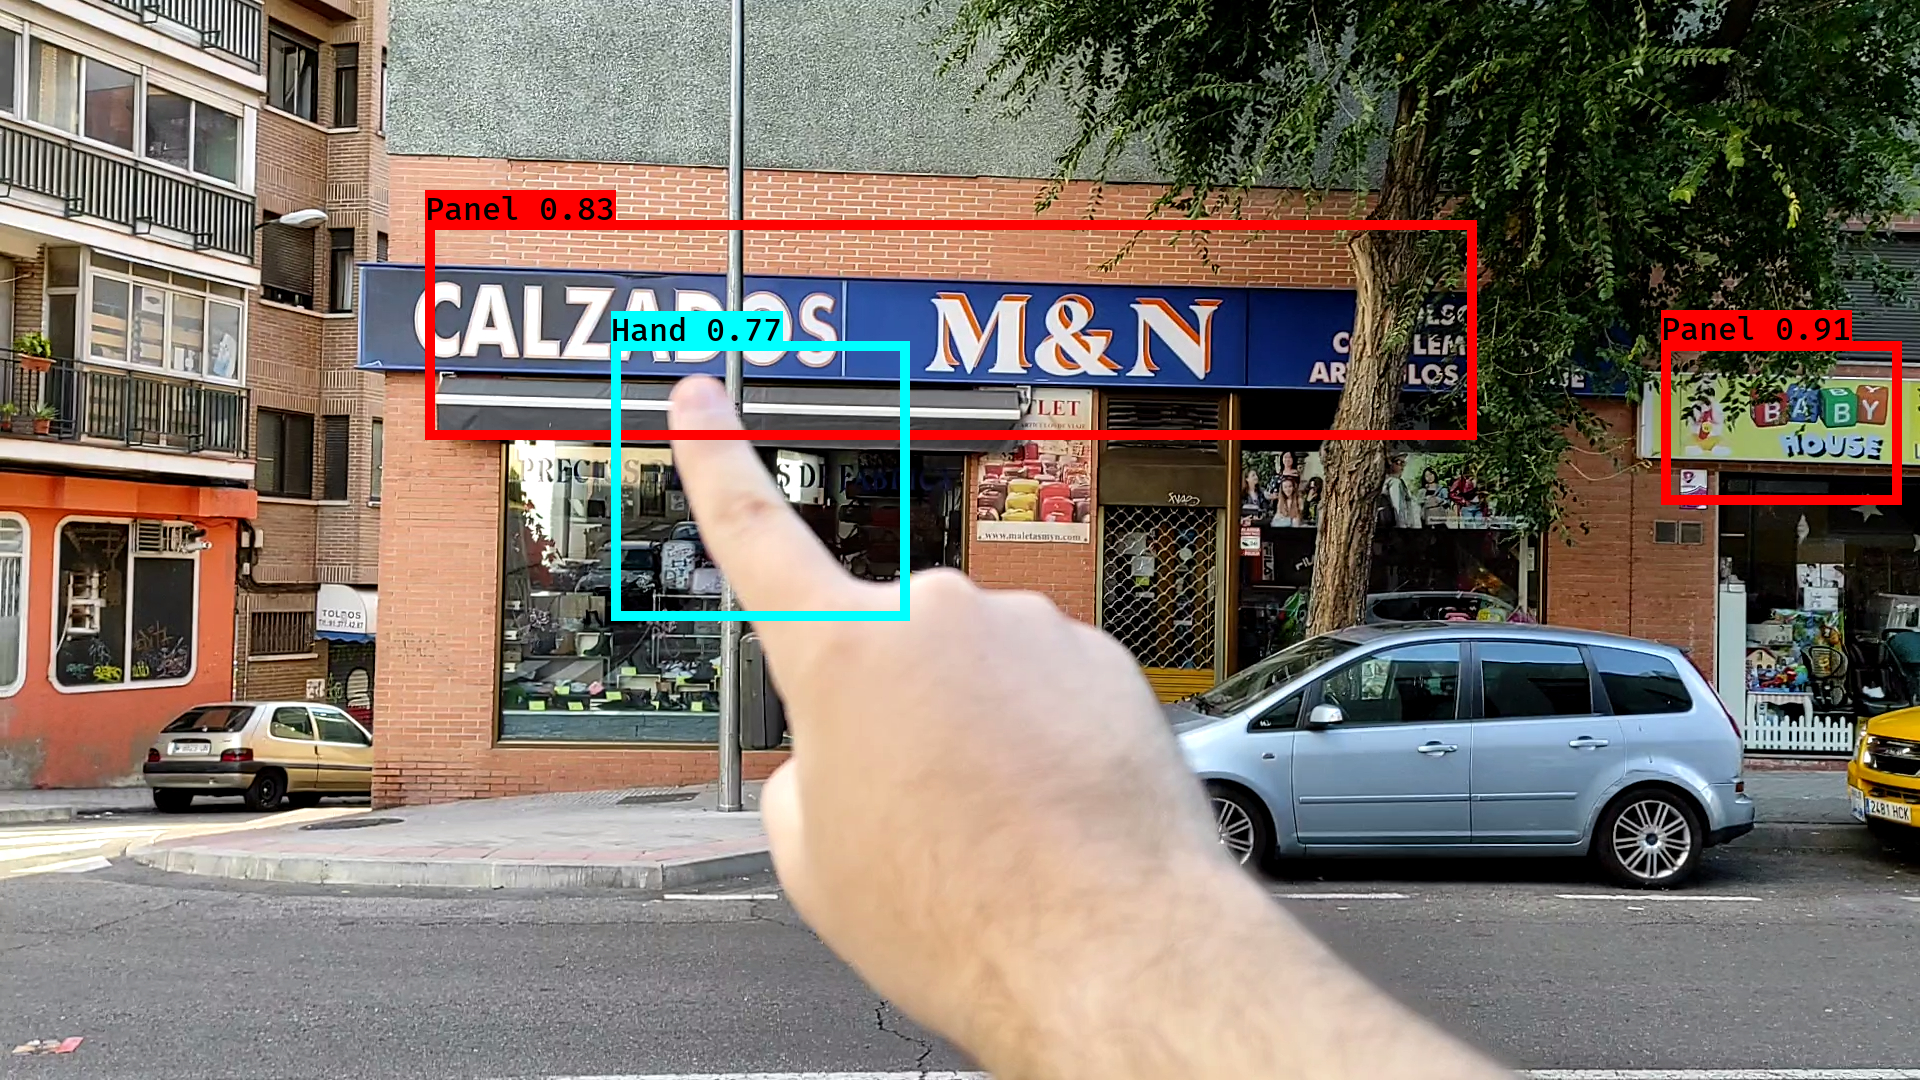

In [5]:
response_detection = data['response']['response_detection']
print(f"Elapsed time: {response_detection['elapsed']}s")
for p in response_detection['payload']['result'][0]['predictions']:
    print("Confidence: %d Class: %d" % (p[-2][-1], p[-2][0]))
msg = base64.b64decode(response_detection['payload']['result'][0]['image'])
buf = io.BytesIO(msg)
img = Image.open(buf)
IPython.display.Image(data=buf.getvalue())

# Paso 2

Después de encontrar solapamiento (en caso de existir varios me quedo con el que maximiza el área) entre un dedo índice y un cartel, corto la imagen por las coordenadas del panel y llamo al servicio de AWS Rekognition.

En la imagen se ilustra el corte, el area donde el OCR ha encontrado texto y los textos.

https://aws.amazon.com/es/rekognition/

Elapsed time: 2.608s
OCR response
------------
CALZAD DS M&N

LEC

LES

AR LOS

LET

CALZAD

DS

M&N

LEC

LES

AR

LOS

LET

*****
Image
-----


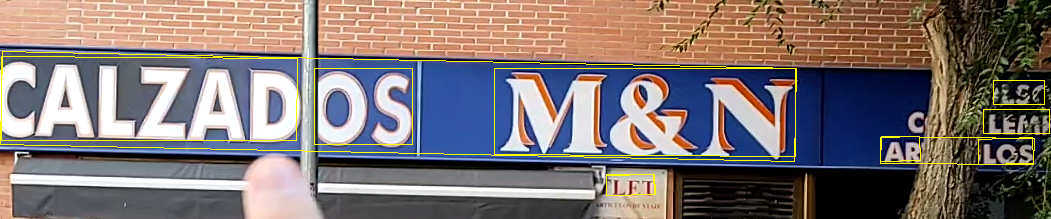

In [6]:
response_rekognition = data['response']['response_rekognition']
print(f"Elapsed time: {response_rekognition['elapsed']}s")
print("OCR response")
print("------------")
for item in response_rekognition['payload']['text']['TextDetections']:
    print(item['DetectedText']+'\n')
print("*****")
print("Image")
print("-----")
msg = base64.b64decode(response_rekognition['payload']['image'])
buf = io.BytesIO(msg)
img = Image.open(buf)
IPython.display.Image(data=buf.getvalue())

# Paso 3

Actualmente sçólo hay un comercio en base de dados (CALZADOS M&N) por lo que calculo la distancia de Levenshtein entre cada texto encontrado por el OCR y el usuario disponible. Soporta sin problemas más usuarios.

Me quedo con el que minimice la distancia (filtrando las que la distancia es mayor que 2/5 partes de la longitud de la cadena que representa al usuario) y recupero de MongoDB los mensajes asociados del usuario detectado (publicados vía Telegram).

In [7]:
response_processing = data['response']['response_processing']
print(f"Elapsed time: {response_processing['elapsed']}s")
print(f"Comprobaciones:")
for item in response_processing['payload']['matches']:
    print(f"Input OCR: {item[2]} Comercio: {item[1]} Distancia: {item[0]}")
print("--------")
print(f"Usuario: {response_processing['payload']['user']}")
print("--------")
print("Mensajes")
print("--------")
for item in response_processing['payload']['messages']:
    print(item+'\n')
    print("--------")

Elapsed time: 0.04s
Comprobaciones:
Input OCR: CALZAD DS M&N Comercio: CALZADOS M&N Distancia: 2
Input OCR: CALZAD Comercio: CALZADOS M&N Distancia: 6
Input OCR: LEC Comercio: CALZADOS M&N Distancia: 9
Input OCR: LES Comercio: CALZADOS M&N Distancia: 9
Input OCR: AR LOS Comercio: CALZADOS M&N Distancia: 9
Input OCR: LET Comercio: CALZADOS M&N Distancia: 9
Input OCR: DS Comercio: CALZADOS M&N Distancia: 9
Input OCR: M&N Comercio: CALZADOS M&N Distancia: 9
Input OCR: LEC Comercio: CALZADOS M&N Distancia: 9
Input OCR: LES Comercio: CALZADOS M&N Distancia: 9
Input OCR: AR Comercio: CALZADOS M&N Distancia: 9
Input OCR: LOS Comercio: CALZADOS M&N Distancia: 9
Input OCR: LET Comercio: CALZADOS M&N Distancia: 9
--------
Usuario: CALZADOS M&N
--------
Mensajes
--------
¡Ven y prueba nuestros maravillosos calzados!

Hoy OFERTA especial 😜

Si es el día de tu cumpleaños podrás beneficiarte de un 2x1*.

¡¡¡Paga uno y llévate dos!!!*

* Oferta aplicable al par de menor valor

--------
